# Exemple série temporelle saisonière 1: monthly milk production
L'ensemble de données décrit une série chronologique de la production de lait (en livres par vache) sur 13 ans (1962-1974), et il y a 156 observations.Nous avons utilisé les premiers 80 % des observations pour entraîner et tester divers modèles tout en retenant les observations restantes pour valider le modèle final.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib

In [45]:
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [46]:
time_series=pd.read_csv('monthly-milk-production-pounds.csv')
time_series.head()

,Month,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [47]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [48]:
time_series['Month']= pd.to_datetime(time_series['Month'])
time_series=time_series.set_index('Month')

In [49]:
time_series.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


## Tracé linéaire
Créons un tracé linéaire pour vérifier les valeurs aberrantes et les tendances et s'il y a une tendance, alors si la tendance semble être stable autour de la moyenne.

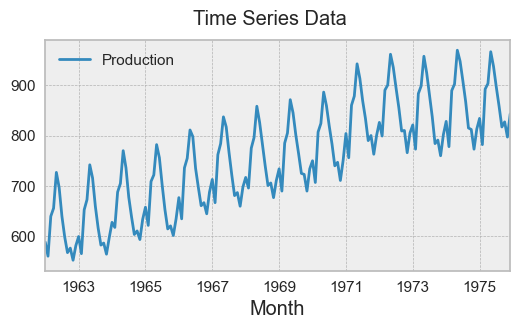

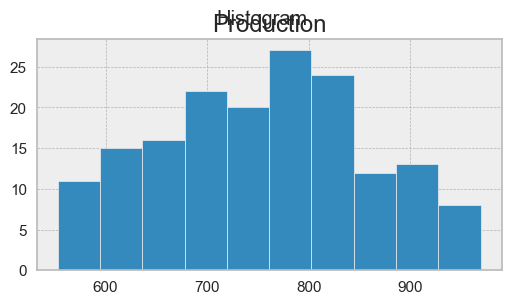

In [50]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
time_series.plot(ax=ax)
plt.show()
#Historgram
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Histogram')
time_series.hist(ax=ax)
plt.show()

<AxesSubplot:xlabel='Month', ylabel='Production'>

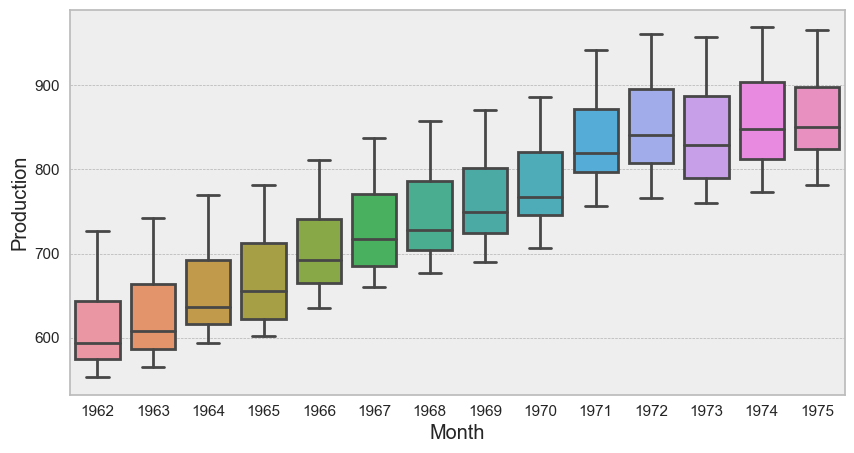

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x = time_series.index.year,
                y = time_series.Production, 
                ax = ax)

## Décomposition d'une série chronologique
On pense qu'une série chronologique donnée se compose de trois composantes systématiques, notamment le niveau, la tendance, la saisonnalité et une composante non systématique appelée bruit. Cela indique à Python comment les composants doivent être combinés pour produire la série chronologique d'origine. La valeur par défaut est additive, c'est ce que nous allons utiliser.


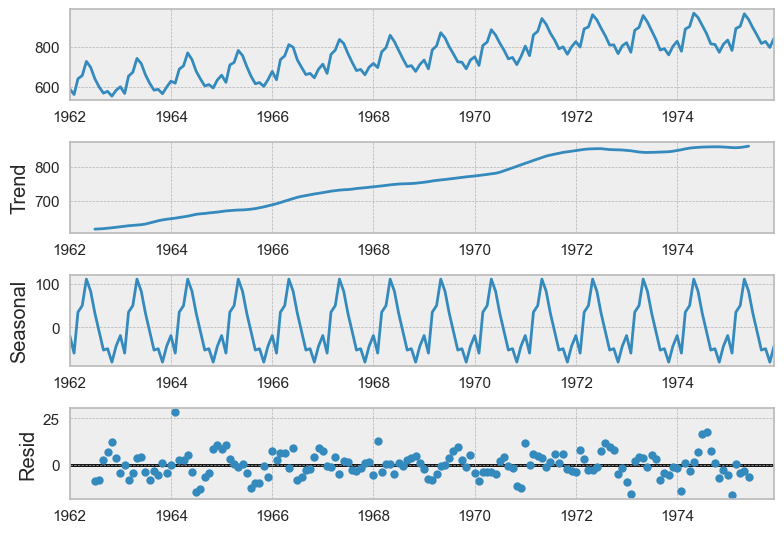

In [54]:
decomp = seasonal_decompose(time_series, period= 12)
decomp.plot()
plt.show()

voici une autre manière de représenter la saisonnalité de la série

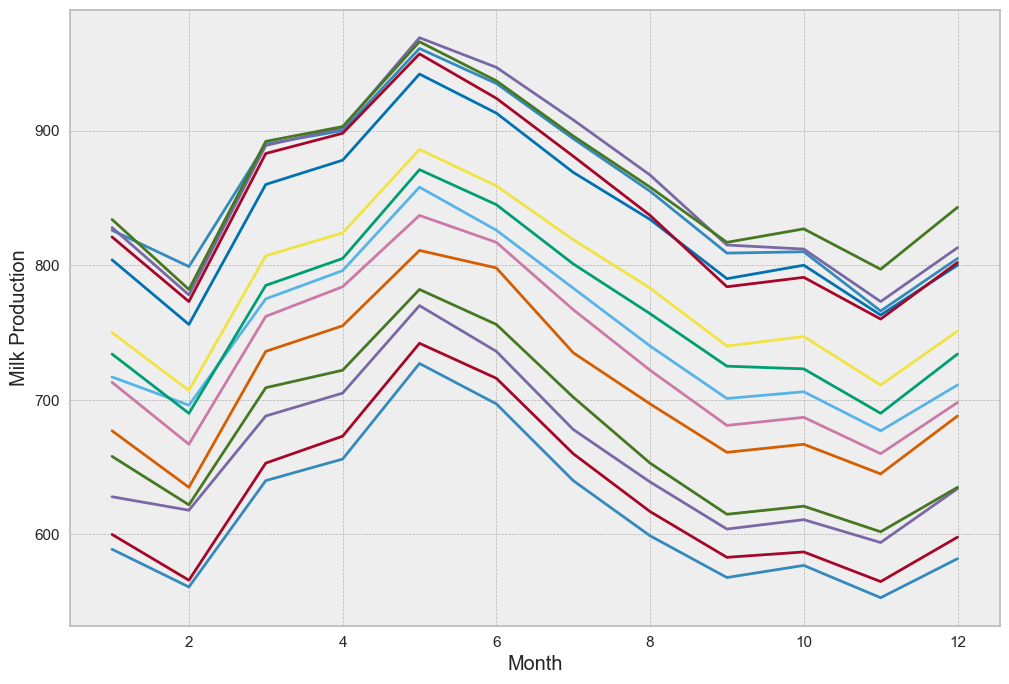

In [56]:
time_series['year'] = time_series.index.year
time_series['month'] = time_series.index.month
df_pivot = pd.pivot_table(time_series, values='Production', index='month', columns='year', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('Month')
plt.ylabel('Milk Production')
plt.show()

## Auto correlation

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


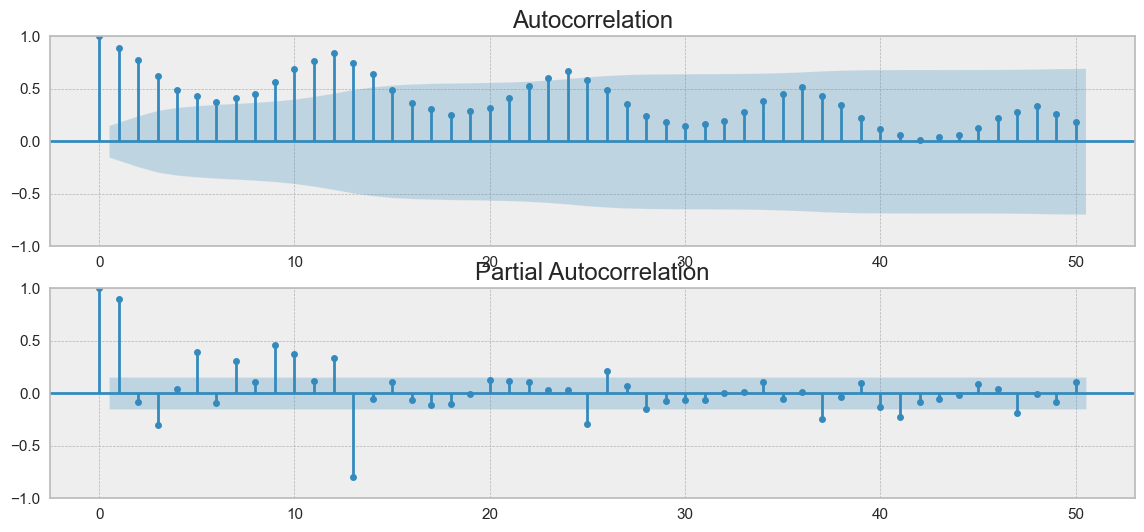

In [57]:
time_series.drop(['year', 'month'], axis=1, inplace=True)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(x=time_series.Production, lags=50, ax=ax1)
ax2 = plot_pacf(time_series.Production, lags=50, ax=ax2)
plt.show()

## Stationary check : test de Dickey–Fuller 
Une série temporelle stationnaire est une série dont les propriétés ne dépendent pas du moment auquel la série est observée. Ainsi, les séries chronologiques avec tendances, ou avec saisonnalité, ne sont pas stationnaires - la tendance et la saisonnalité affecteront la valeur de la série chronologique à des moments différents. Peu importe le moment où vous l'observez, il devrait se ressembler à tout moment. Nous avons donc déjà une intuition maintenant que ce n'est pas stationnaire, mais testons-le à l'aide de Dicey Fuller Test.
Le test de Dickey – Fuller teste l'hypothèse nulle selon laquelle une racine unitaire est présente dans un modèle de série chronologique autorégressif. L'hypothèse alternative est différente selon la version du test utilisée, mais il s'agit généralement de stationnarité ou de tendance-stationnarité.

1-Si la valeur de p est inférieure à la valeur seuil (5 % ou 1 %), nous rejetons l'hypothèse nulle et la série temporelle est stationnaire.

2-Si la valeur de p est supérieure au seuil, nous ne rejetons pas l'hypothèse nulle et la série chronologique n'est pas stationnaire.

In [58]:
result = adfuller(time_series['Production'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.303812
p-value: 0.627427
Critical Test Statistics Values:
	1%: -3.474
	5%: -2.880
	10%: -2.577


## Differencier les données: transformer une série redondante en une série stationnaire

In [4]:
#time_series=time_series.set_index('Month')
time_series_diff = time_series.diff(12)
time_series_diff.dropna(inplace=True)

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
time_series_diff.plot(ax=ax)
plt.show()

NameError: name 'time_series' is not defined

On teste une nouvelle fois Dickey Fuller test, et on vois que p value a baissé et nous regardons l'évolution de l'auto corrélation

In [60]:
result = adfuller(time_series_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.038002
p-value: 0.000019
Critical Test Statistics Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


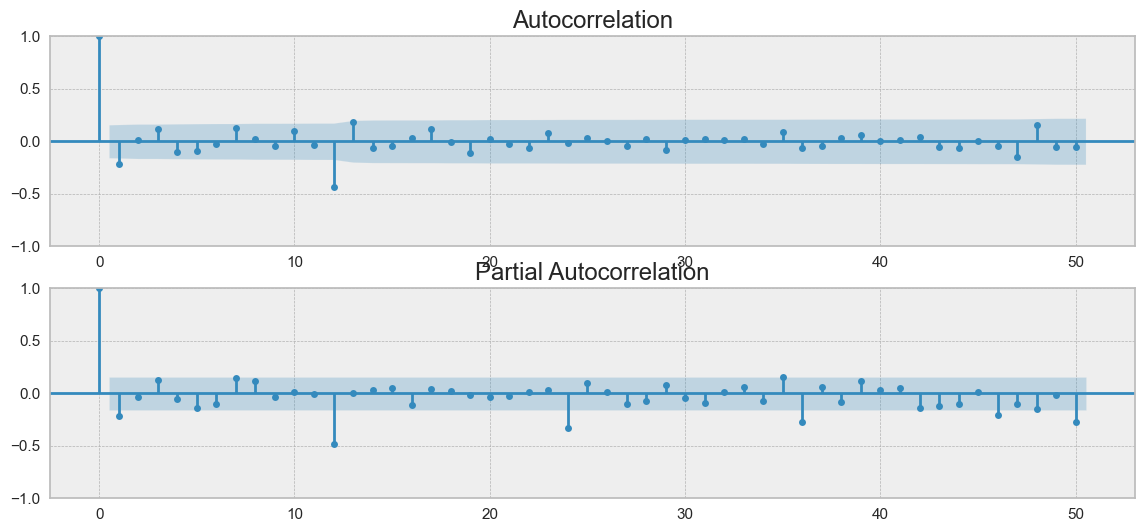

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(x=time_series_diff, lags=50, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=50, ax=ax2)
plt.show()

## Estimation des paramètres du modèle
### ARIMA


In [62]:
import pmdarima as pm
model = pm.auto_arima(time_series['Production'], d=1, D=1,seasonal=True, m=12, trend='c',start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1076.128, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1121.939, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1083.569, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1068.286, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1116.950, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1070.017, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1069.963, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1084.109, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1074.277, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1070.056, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1069.791, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1068.200, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1116.800, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]

On divise notre dataset en test et train, afin d'entrainer le modèle.

<AxesSubplot:xlabel='Month'>

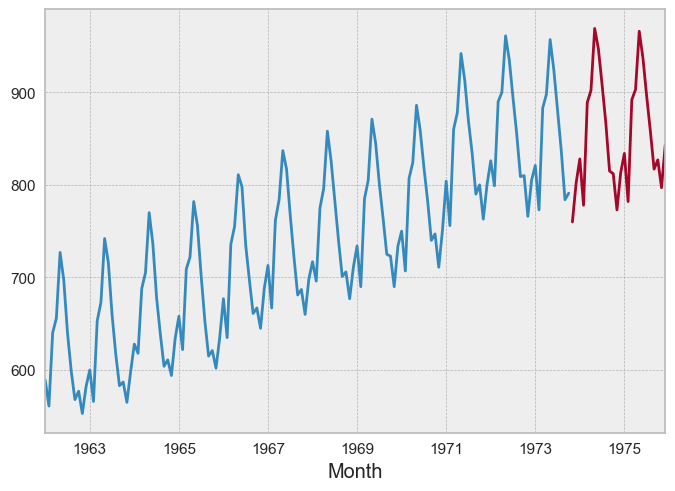

In [63]:
#diviser en train et test
train = time_series[:int(0.85*(len(time_series)))]
test = time_series[int(0.85*(len(time_series))):]

#plotting the data
train['Production'].plot()
test['Production'].plot()

Nous utilisons SARIMAX

In [64]:
model = SARIMAX(train['Production'],order=(1,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
print("Results of SARIMAX on train")
print(results.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Results of SARIMAX on train
                                      SARIMAX Results                                       
Dep. Variable:                           Production   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -445.603
Date:                              Tue, 03 Jan 2023   AIC                            897.205
Time:                                      17:05:07   BIC                            905.785
Sample:                                  01-01-1962   HQIC                           900.691
                                       - 10-01-1973                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.087     -3.149      0.002      -0.443    

## Validation

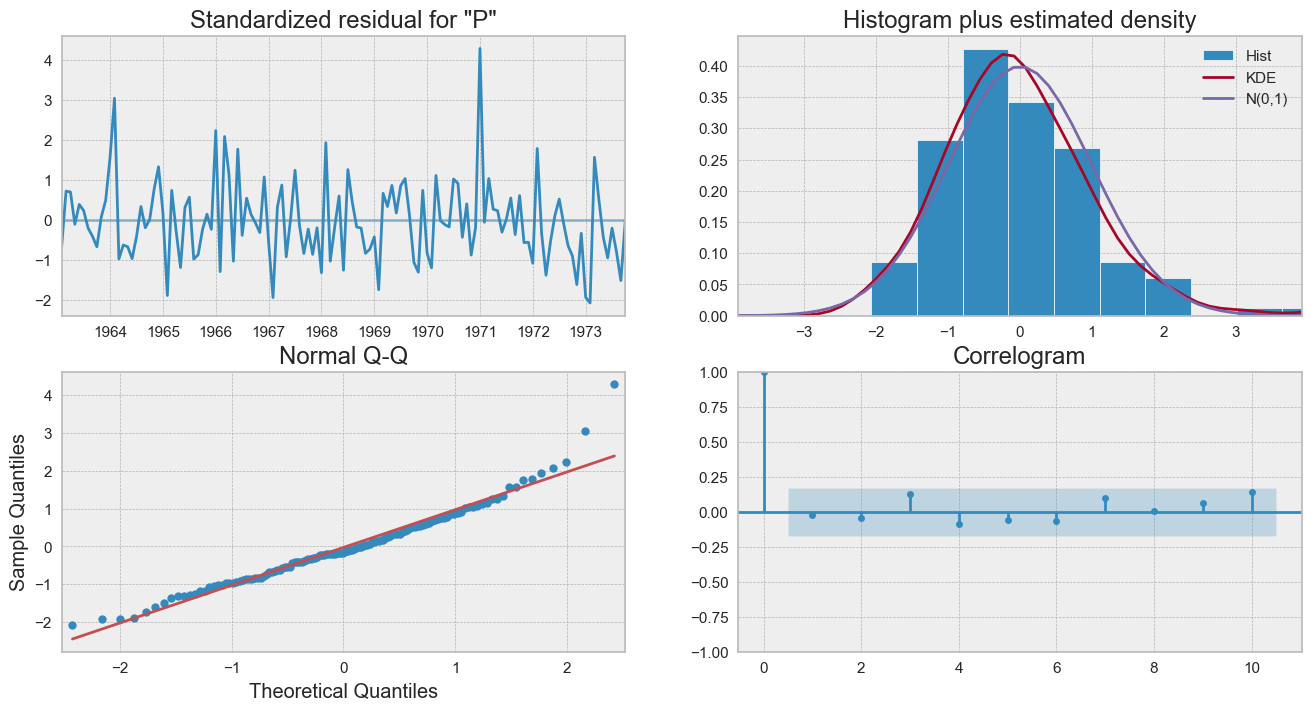

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

Pour mesurer l'accuracy de nos prévisions, nous comparons les valeurs prédites aux valeurs mesurées.

### Prédictions effectuées sur les données test

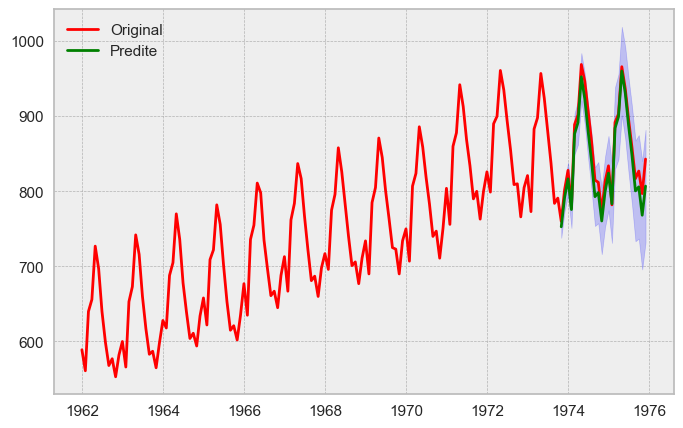

In [24]:
forecast = results.get_forecast(steps=len(test))
mean = forecast.predicted_mean
conf_int = forecast.conf_int()
d = mean.index
plt.figure(figsize=(8,5))
# Plot past  levels
plt.plot(time_series.index, time_series, label='Original', color = 'red')
# Prediction Mean
plt.plot(d, mean, label='Predite', color= 'green')
# Shade of space between  confidence intervals
plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2, color= 'blue')
# Plot legend 
plt.legend()
plt.savefig('p')
plt.show()

In [32]:
from sklearn.metrics import r2_score
print('R2score is',r2_score(test['Production'], mean))
mean_absolute_percentage_error = np.mean(np.abs(mean - test['Production'])/np.abs(test['Production']))*100
print('MAPE is', mean_absolute_percentage_error)

R2score is 0.924043368649106
MAPE is 1.6499054671142013


Nous avons testé notre modèle sur des valeurs déja existantes, nous pouvons continuer à lles prédire dansle futur.

## Prédiction sur l'avenir

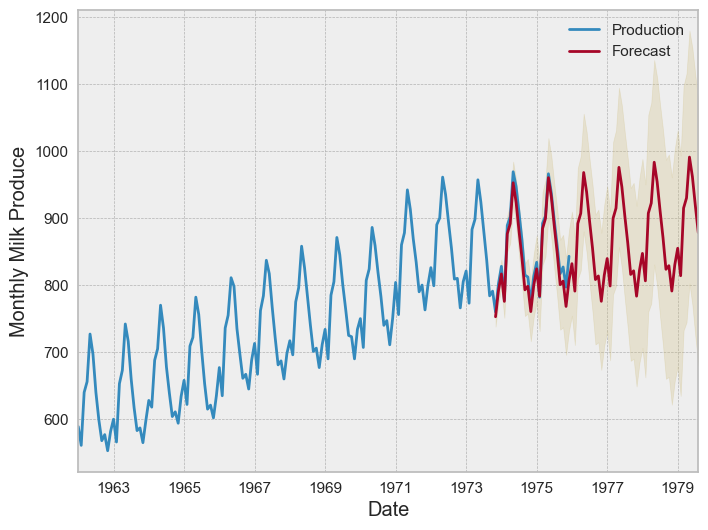

In [34]:
#Future Forecast
future = results.get_forecast(steps=70)
ci = future.conf_int()
ax = time_series.plot(label='Production', figsize=(8, 6))
future.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='y', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Milk Produce')
plt.legend()
plt.show()